In [2]:
import os
import platform

def add_latex_to_path():
    system = platform.system()
    
    if system == 'Darwin':  # macOS
        # Common MacTeX paths
        latex_paths = [
            '/Library/TeX/texbin',
            '/usr/local/texlive/2023/bin/universal-darwin',  # Adjust year as needed
            '/usr/local/texlive/2022/bin/universal-darwin',
        ]
    elif system == 'Linux':
        latex_paths = [
            '/usr/local/texlive/2023/bin/x86_64-linux',  # Adjust year as needed
            '/usr/local/texlive/2022/bin/x86_64-linux',
        ]
    elif system == 'Windows':
        latex_paths = [
            r'C:\texlive\2023\bin\win32',  # Adjust year as needed
            r'C:\Program Files\MiKTeX\miktex\bin\x64',
            r'C:\Program Files (x86)\MiKTeX\miktex\bin',
        ]
    else:
        raise OSError(f"Unsupported operating system: {system}")

    # Get current PATH
    current_path = os.environ.get('PATH', '')
    
    # Add LaTeX paths that exist
    for latex_path in latex_paths:
        if os.path.exists(latex_path) and latex_path not in current_path:
            os.environ['PATH'] = latex_path + os.pathsep + os.environ['PATH']
            print(f"Added to PATH: {latex_path}")

    # Verify latex is now accessible
    import shutil
    latex_executable = shutil.which('latex')
    if latex_executable:
        print(f"LaTeX found at: {latex_executable}")
    else:
        print("LaTeX still not found in PATH. Make sure it's installed correctly.")

# Add LaTeX to PATH
add_latex_to_path()

LaTeX found at: /usr/bin/latex


In [3]:
import os
import jupyter_black
import shutil
import matplotlib.pyplot as plt
import umap
import scprep
import pandas as pd
import numpy as np
import scipy
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.latex.preamble'] = r'''
\usepackage{txfonts}
\usepackage{xspace}
\usepackage[dvipsnames,svgnames,x11names]{xcolor}
\definecolor{CustomPurple}{HTML}{756FB3}  % Using HTML color code
% Or use RGB values (divide by 255):
% \definecolor{CustomPurple}{rgb}{0.459,0.435,0.702}
\newcommand{\methodname}{\textsc{SuperDiff}}
\newcommand{\AND}{\texttt{\textcolor{CustomPurple}{\textbf{AND}}}\xspace}
\newcommand{\OR}{\texttt{\textcolor{CustomPurple}{\textbf{OR}}}\xspace}
'''

#\usepackage[dvipsnames,svgnames,x11names]{xcolor}
#\newcommand{\methodname}{\textsc{SuperDiff}}
#\definecolor{CustomPurple}{RGB}{117,111,179}
#\newcommand{\AND}{\textcolor{CustomPurple}{\texttt{{\textbf{AND}}}}\xspace}
#\newcommand{\OR}{\textcolor{CustomPurple}{\texttt{{\textbf{OR}}}}\xspace}


In [4]:
directory = "/projects/superdiff/generated_proteins/final/"

In [5]:
os.listdir(directory)

['BASELINE_proteus.tar.gz',
 'composition_bothkappa_sde_500t_temp1_logp1_METHOD2_202410_2LIN',
 'framediff_sde_202410',
 'composition_bothkappa_sde_500t_temp1_logp0_METHOD2_202410_2LIN',
 'mixing_0.6',
 'mixing_0.9',
 'mixing_0.7',
 'BASELINE_framediff.tar.gz',
 'mixing_0.4',
 'mixing_0.5_202410',
 'mixing_0.8',
 'proteus_sde_202410',
 'composition_bothkappa_sde_500t_AND_logp0_logsigma_f64',
 'OURS_OR_temp1_logp0_default.tar.gz',
 'OURS_OR_temp1_logp1_best.tar.gz',
 'BASELINE_averaging.tar.gz',
 'mixing_0.2',
 'mixing_0.1',
 'mixing_0.3']

In [5]:
model_dirs = ['proteus_sde_202410',
 'framediff_sde_202410',
 'composition_bothkappa_sde_500t_temp1_logp0_METHOD2_202410_2LIN',]

In [6]:
def run_foldseek(model_dirs):
    os.makedirs("concat_pdbs", exist_ok=True)
    for model_dir in model_dirs:
        model = model_dir.split("_")[0]
        dir = os.path.join(directory, model_dir)
        for length_dir in os.listdir(dir):
            length = length_dir[-3:]
            model_output_dir = os.path.join(dir, length_dir, "model_outputs")
            for pdb in os.listdir(model_output_dir):
                pdb_path = os.path.join(model_output_dir, pdb)
                dst = f"concat_pdbs/model_{model}_length_{length}_{pdb}"
                shutil.copy(pdb_path, dst)
                
                
    !foldseek createdb concat_pdbs pdb_database_v2
    !foldseek easy-cluster concat_pdbs/ res_v2 /tmp -c 0.9 

    cluster_df = pd.read_csv("res_v2_cluster.tsv", sep="\t", header=None)
    cluster_df.columns=["representative", "member"]
    cluster_df.representative.value_counts()
    pd.DataFrame(list(cluster_df.representative.str.split("_").values))
    
    !foldseek easy-search pdb_database_v2 pdb_database_v2 aln_v2 tmp --format-output query,target,alntmscore --tmscore-threshold 0.3 -v 3
    
    tm_scores = pd.read_csv("aln_v2", sep="\t", header=None)
    tm_scores.columns = ["source", "target", "tmscore"]
    
    shutil.rmtree("concat_pdbs")
    
    return tm_scores, cluster_df

In [7]:
def make_umap(df, cluster_df, model_dirs, save_name, replace_names, colors=['#1b9e77','#d95f02','#7570b3']):
    fig, ax = plt.subplots()

    all_nodes = pd.concat([df['source'], df['target']]).unique()
    node_mapping = {node: idx for idx, node in enumerate(all_nodes)}
    df['source_idx'] = df['source'].map(node_mapping)
    df['target_idx'] = df['target'].map(node_mapping)
    cluster_df["representative_idx"] = cluster_df["representative"].map(node_mapping)
    
    # Step 2: Convert to sparse matrix (using tmscore as the data)
    sparse_matrix = scipy.sparse.coo_matrix((df['tmscore'], (df['source_idx'], df['target_idx'])))
    
    # Print sparse matrix
    
    node_df = pd.DataFrame(list(node_mapping.keys()))
    node_df.columns=["sample"]
    #node_df.apply(str.split("_"))
    split_columns = node_df['sample'].str.split('_', expand=True)
    split_columns.columns = ['model_type', 'model_name', 'length_type', "length", 'sample_type', 'sample_number']
    split_columns.drop(columns=["model_type", "length_type", "sample_type"])
    
    mapper = umap.UMAP(metric="euclidean", n_neighbors=20, min_dist=1,
                       random_state=32, low_memory=True).fit_transform(sparse_matrix)
    split_columns["nice_names"] = split_columns["model_name"].replace(replace_names)
    np.random.seed(4)
    scprep.plot.scatter2d(mapper, c=split_columns["nice_names"], cmap=colors, s=10, ax=ax)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    

    # Remove borders (spines)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    
    plt.savefig(save_name, dpi=600)
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    return mapper, split_columns
    

In [45]:
model_dirs = ['proteus_sde_202410',
 'framediff_sde_202410',
 'composition_bothkappa_sde_500t_temp1_logp0_METHOD2_202410_2LIN',]
replace_names = {"composition": r"\methodname \, (\OR)", "framediff": "FrameDiff", "proteus": "Proteus"}
save_name = "umap_superdiff_or_l1.png"


In [46]:
df_or, cluster_df_or = run_foldseek(model_dirs)

pdb_database_v2 exists and will be overwritten
createdb concat_pdbs pdb_database_v2 

MMseqs Version:        	928984bfa3c7c3c98ca58b557d965965038f7e0b
Path to ProstT5        	
Chain name mode        	0
Write mapping file     	0
Mask b-factor threshold	0
Coord store mode       	2
Write lookup file      	1
Input format           	0
File Inclusion Regex   	.*
File Exclusion Regex   	^$
Threads                	32
Verbosity              	3

Output file: pdb_database_v2
[=================================================================] 100.00% 750 0s 443ms    
Time for merging to pdb_database_v2_ss: 0h 0m 0s 17ms
Time for merging to pdb_database_v2_h: 0h 0m 0s 20ms
Time for merging to pdb_database_v2_ca: 0h 0m 0s 19ms
Time for merging to pdb_database_v2: 0h 0m 0s 14ms
Ignore 0 out of 750.
Too short: 0, incorrect: 0, not proteins: 0.
Time for processing: 0h 0m 0s 596ms
easy-cluster concat_pdbs/ res_v2 /tmp -c 0.9 

MMseqs Version:                     	928984bfa3c7c3c98ca58b557d965965038f7e0b

/h/mskrt/.conda/envs/SE3nv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


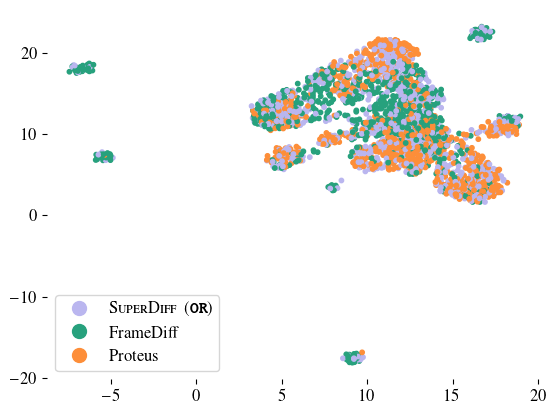

In [51]:
colors={r"\methodname \, (\OR)":'#7570b3', "FrameDiff": '#1b9e77', "Proteus":'#d95f02'}
colors={r"\methodname \, (\OR)":'#BAB6EF', "FrameDiff": '#27A17D', "Proteus":'#FD8E39'}

mapper, split_columns = make_umap(df_or, cluster_df_or, model_dirs, save_name, replace_names, colors=colors)


In [24]:
full_df = split_columns.copy()
x = [m[0] for m in mapper]
y = [m[1] for m in mapper]
full_df['x'] = x
full_df['y'] = y
full_df = full_df[full_df['nice_names'] == r"\methodname \, (\OR)"]

x_min = -10
x_max = 0
y_min = 0
y_max = 5
full_df[(full_df['x'] > x_min) & (full_df['x'] < x_max) & 
         (full_df['y'] > y_min) & (full_df['y'] < y_max)]

,model_type,model_name,length_type,length,sample_type,sample_number,nice_names,x,y


,source,target,tmscore,source_idx,target_idx
0,model_framediff_length_300_sample_52,model_framediff_length_300_sample_52,1.0000,0,0
1,model_framediff_length_300_sample_52,model_composition_length_300_sample_52,0.6132,0,514
2,model_framediff_length_300_sample_52,model_proteus_length_250_sample_167,0.4895,0,2840
3,model_framediff_length_300_sample_52,model_framediff_length_300_sample_32,0.3509,0,2867
4,model_framediff_length_300_sample_52,model_framediff_length_300_sample_7,0.3417,0,643
...,...,...,...,...,...
1030510,model_framediff_length_300_sample_25,model_composition_length_150_sample_123,0.3807,2999,1539
1030511,model_framediff_length_300_sample_25,model_composition_length_200_sample_182,0.3190,2999,706
1030512,model_framediff_length_300_sample_25,model_proteus_length_150_sample_155,0.3021,2999,2396
1030513,model_framediff_length_300_sample_25,model_framediff_length_150_sample_124,0.3102,2999,1274


In [8]:
model_dirs = ['proteus_sde_202410',
 'framediff_sde_202410',
 'composition_bothkappa_sde_500t_AND_logp0_logsigma_f64',]

df_and, cluster_df_and = run_foldseek(model_dirs)

pdb_database_v2 exists and will be overwritten
createdb concat_pdbs pdb_database_v2 

MMseqs Version:        	928984bfa3c7c3c98ca58b557d965965038f7e0b
Path to ProstT5        	
Chain name mode        	0
Write mapping file     	0
Mask b-factor threshold	0
Coord store mode       	2
Write lookup file      	1
Input format           	0
File Inclusion Regex   	.*
File Exclusion Regex   	^$
Threads                	32
Verbosity              	3

Output file: pdb_database_v2
[=================================================================] 100.00% 3.00K 1s 537ms    
Time for merging to pdb_database_v2_ss: 0h 0m 0s 59ms
Time for merging to pdb_database_v2_h: 0h 0m 0s 57ms
Time for merging to pdb_database_v2_ca: 0h 0m 0s 62ms
Time for merging to pdb_database_v2: 0h 0m 0s 57ms
Ignore 0 out of 3000.
Too short: 0, incorrect: 0, not proteins: 0.
Time for processing: 0h 0m 1s 948ms
easy-cluster concat_pdbs/ res_v2 /tmp -c 0.9 

MMseqs Version:                     	928984bfa3c7c3c98ca58b557d965965038f7

/h/mskrt/.conda/envs/SE3nv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(array([[ 4.1584373, -0.3003447],
        [ 5.57475  , -2.4695382],
        [ 7.694008 , -5.7832813],
        ...,
        [14.71335  ,  7.075131 ],
        [ 4.8506455, -4.392941 ],
        [10.387367 , -4.645129 ]], dtype=float32),
      model_type   model_name length_type length sample_type sample_number  \
 0         model  composition      length    200      sample           172   
 1         model    framediff      length    300      sample           171   
 2         model  composition      length    300      sample            92   
 3         model  composition      length    100      sample           119   
 4         model  composition      length    100      sample            84   
 ...         ...          ...         ...    ...         ...           ...   
 2995      model    framediff      length    250      sample            90   
 2996      model  composition      length    100      sample            42   
 2997      model  composition      length    150      sample    

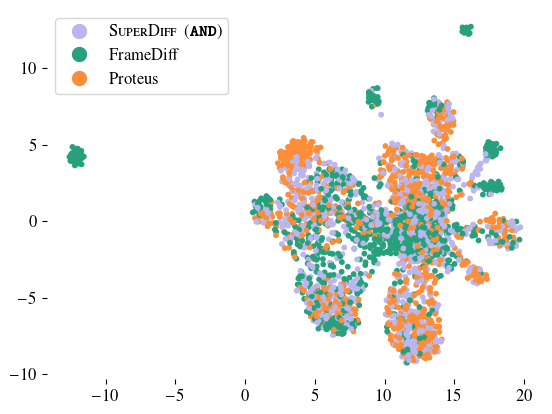

In [10]:
colors={r"\methodname \, (\AND)":'#BAB6EF', "FrameDiff": '#27A17D', "Proteus":'#FD8E39'}
replace_names = {"composition": r"\methodname \, (\AND)", "framediff": "FrameDiff", "proteus": "Proteus"}
save_name = "umap_superdiff_and.png"
make_umap(df_and, cluster_df_and, model_dirs, save_name, replace_names, colors=colors)

In [11]:
model_dirs = ['proteus_sde_202410',
 'framediff_sde_202410',
 'mixing_0.5_202410',]

df_avg, cluster_df_avg = run_foldseek(model_dirs)

pdb_database_v2 exists and will be overwritten
createdb concat_pdbs pdb_database_v2 

MMseqs Version:        	928984bfa3c7c3c98ca58b557d965965038f7e0b
Path to ProstT5        	
Chain name mode        	0
Write mapping file     	0
Mask b-factor threshold	0
Coord store mode       	2
Write lookup file      	1
Input format           	0
File Inclusion Regex   	.*
File Exclusion Regex   	^$
Threads                	32
Verbosity              	3

Output file: pdb_database_v2
[=================================================================] 100.00% 3.00K 1s 551ms    
Time for merging to pdb_database_v2_ss: 0h 0m 0s 16ms
Time for merging to pdb_database_v2_h: 0h 0m 0s 16ms
Time for merging to pdb_database_v2_ca: 0h 0m 0s 45ms
Time for merging to pdb_database_v2: 0h 0m 0s 51ms
Ignore 0 out of 3000.
Too short: 0, incorrect: 0, not proteins: 0.
Time for processing: 0h 0m 1s 813ms
easy-cluster concat_pdbs/ res_v2 /tmp -c 0.9 

MMseqs Version:                     	928984bfa3c7c3c98ca58b557d965965038f7

/h/mskrt/.conda/envs/SE3nv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(array([[ 1.7741201 ,  8.456975  ],
        [-0.66418254, -3.8739328 ],
        [-7.136204  , -0.9691135 ],
        ...,
        [-4.353165  , -2.1720877 ],
        [ 8.273729  ,  3.5226524 ],
        [ 0.83511865, -6.9400916 ]], dtype=float32),
      model_type model_name length_type length sample_type sample_number  \
 0         model    proteus      length    200      sample           197   
 1         model     mixing      length    150      sample            11   
 2         model    proteus      length    100      sample           123   
 3         model    proteus      length    200      sample           163   
 4         model  framediff      length    100      sample           156   
 ...         ...        ...         ...    ...         ...           ...   
 2995      model     mixing      length    100      sample           135   
 2996      model     mixing      length    100      sample            16   
 2997      model     mixing      length    150      sample            

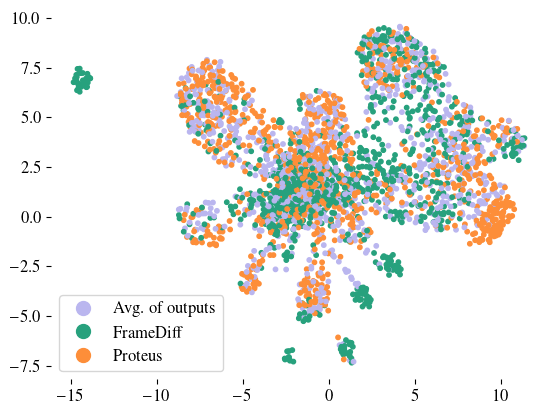

In [13]:
colors=['#7570b3', '#1b9e77','#d95f02',]
replace_names = {"mixing": "Avg. of outputs", "framediff": "FrameDiff", "proteus": "Proteus"}
save_name = "umap_superdiff_avg.png"
colors={"Avg. of outputs":'#BAB6EF', "FrameDiff": '#27A17D', "Proteus":'#FD8E39'}

make_umap(df_avg, cluster_df_avg, model_dirs, save_name, replace_names, colors)